In [37]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from src.path_loss import PathLossInHIndoorOffice, PathLossInHShoppingMalls
from src.network_sim import NetworkSimulator
from src.algorithm import wmmse, stochastic_wmmse
from src.sc import SyntheticControl
from src.experiment import ExperimentInterferenceModelComparison

%reload_ext autoreload
%autoreload 2
%aimport src

In [38]:
frequency_Hz= 50 * 1e9 # Hz
distance_m = 50
sample_size = 10

In [39]:
pd.DataFrame({
    'PathLossInHIndoorOffice':[PathLossInHIndoorOffice().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
    'PathLossInHShoppingMalls': [PathLossInHShoppingMalls().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
})

,PathLossInHIndoorOffice,PathLossInHShoppingMalls
0,-117.505699,-106.087233
1,-138.360218,-103.037218
2,-130.426810,-109.313872
3,-130.472858,-113.695581
4,-125.652916,-98.045159
5,-134.477504,-94.922633
6,-122.565232,-93.362923
7,-134.739863,-108.386008
8,-132.549417,-115.078875
9,-137.680066,-111.770265


In [40]:
simulator = NetworkSimulator(Tx_radius=200, Rx_radius=25, num_Tx_netA=5, num_Rx_per_Tx_netA=10, num_Tx_netB=3, num_Rx_per_Tx_netB=10)


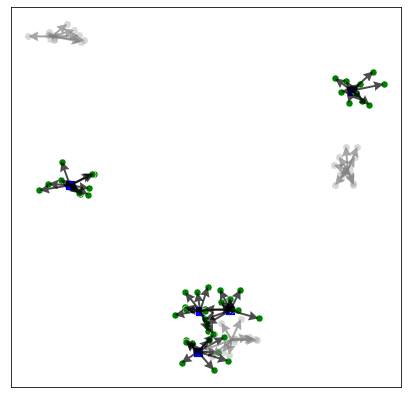

In [41]:
simulator.plot_network()

In [42]:
pd.DataFrame(simulator.gain_mat_dBm)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-104.069928,-99.682425,-110.880543,-93.522207,-97.086791,-89.327284,-104.084650,-100.669252,-89.582657,-91.328435,...,-153.239530,-169.645184,-156.005418,-159.314580,-158.738345,-157.181610,-158.989984,-182.101484,-154.758157,-167.639460
1,-111.466520,-87.772173,-109.562536,-100.563140,-104.884869,-96.167655,-111.081434,-108.611369,-107.947938,-108.873558,...,-164.870570,-162.159487,-162.929528,-157.502773,-157.789679,-168.278365,-156.746600,-159.238525,-171.706787,-161.437416
2,-101.526277,-96.016831,-80.274852,-98.410743,-96.285943,-99.742311,-92.370648,-107.340868,-105.340276,-87.250300,...,-153.935037,-149.110985,-154.067562,-152.823103,-156.211863,-165.310954,-163.320492,-157.655599,-156.689967,-167.468087
3,-151.805248,-163.120183,-162.376157,-151.611987,-141.926176,-149.862065,-156.717632,-142.360483,-150.975506,-143.027108,...,-163.152760,-138.040174,-151.984100,-152.928251,-148.483852,-138.226269,-149.772678,-150.949761,-157.314052,-150.456843
4,-153.152536,-139.866835,-133.745203,-143.806718,-129.709774,-134.983074,-137.622539,-145.034495,-138.147988,-129.099079,...,-127.840614,-126.806774,-119.448123,-124.567229,-138.561048,-127.386884,-123.404981,-121.296477,-126.779694,-110.097736
5,-127.024777,-131.790318,-146.692768,-123.505271,-134.315646,-149.870812,-147.349769,-133.777577,-123.149756,-128.470662,...,-156.706086,-148.428892,-154.350834,-150.261010,-155.129533,-153.496938,-155.901067,-156.527481,-155.406772,-159.326624
6,-106.261645,-105.225649,-110.788735,-103.722029,-113.770864,-95.863342,-93.820132,-107.035164,-108.988370,-101.651923,...,-163.322163,-161.630208,-162.632599,-171.056600,-167.228064,-159.124292,-170.495232,-164.983135,-171.954620,-172.440941
7,-159.694002,-168.011125,-154.746049,-168.007193,-170.629082,-149.980706,-146.204698,-164.130717,-153.161930,-160.669145,...,-103.600179,-91.968603,-107.981639,-114.631502,-81.693743,-80.376019,-83.755326,-98.719050,-87.502233,-74.188565


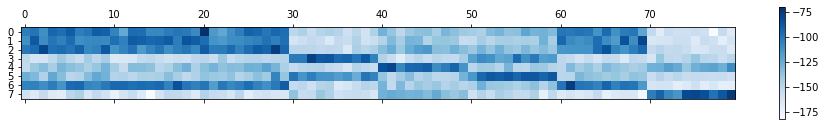

In [43]:
simulator.plot_gain_mat()

## Model Comparisons

In [44]:
simulator.weighted_sum_rate_Gnats([200 for i in range(simulator.num_Rx)], Rx_weights=np.ones(simulator.num_Rx), part='A')

305.12039679212296

In [45]:
# model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
# model_comparison.data_generation(num_samples=100, max_power=500, netB_power_mode='zero')
# model_comparison.modeling()

In [46]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='zero')

In [47]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='dependent')

In [48]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='uniform')

## Algorithm Comparisons

In [49]:
max_power = 200
netB_power_training_mode = 'dependent' # ['dependent', 'zero', 'random']
netB_power_testing_mode = 'dependent' # ['dependent', 'zero', 'random', 'uniform']

max_iterations = 300

model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
model_comparison.data_generation(num_samples=1000, max_power=max_power, netB_power_mode=netB_power_training_mode)
model_comparison.modeling(synthetic_constrained=True)
starting_powers_mW = [1e-5 for i in range(simulator.num_Rx)]
# Rx_weights = np.random.uniform(0.1, 1, simulator.num_Rx)
Rx_weights = np.ones(simulator.num_Rx)

In [50]:
rates_original_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='original',
    interference_models=[],
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

Denominator: 1.239253397684266e-07
Weighted Sum Rate: 170.91331931277844
Power: [ 0.          0.          0.          0.          0.          0.
  0.          0.         28.65170426  0.          0.          0.
  0.          0.          0.          0.          0.          0.
 74.138315    0.          0.          0.          0.          0.
  0.          0.          0.          0.         25.83271586  0.
  0.          0.         46.49779078  0.          0.          0.
  0.          0.          0.          0.          0.          0.71172966
  0.          0.          0.          0.          0.          0.
  0.          0.        ], [ 69.75713377   0.           0.           0.           0.
   0.           0.           0.          80.27868671 123.70052469
   0.           0.           0.           0.           0.
   0.          33.59151772   0.           0.           0.
  40.65753011   0.          27.63064931   0.          53.41733088
   0.          45.81444053  32.14411409  79.67832413   0.  

In [51]:
# rates_local_method = stochastic_wmmse(
#     simulator=simulator,
#     Rx_powers_mW=starting_powers_mW,
#     Rx_max_powers_mW=max_power,
#     Rx_weights=Rx_weights,
#     interference_mode='local',
#     interference_models=[],
#     netB_power_mode = netB_power_testing_mode,
#     power_corr_mat=model_comparison.power_corr_mat,
#     max_iter=max_iterations,
# );

In [52]:
rates_sc_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='sc_estimate',
    interference_models=model_comparison.sc_models,
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

Denominator: 5.201614383205798e-07
Weighted Sum Rate: 224.38196469868464
Power: [  0.           0.           0.           0.           0.
   0.           0.           0.         200.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.         200.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.         199.46436281   0.
   0.           0.         190.51324594   0.           0.
   0.           0.           0.           0.           0.
   0.         195.67475059   0.           0.           0.
   0.           0.           0.           0.           0.        ], [200.          69.90627156   0.          27.47432383   0.
   0.           0.         122.06498483 200.         200.
  57.92163721   0.           0.          50.02397312   0.
   0.         200.           0.           0.           0.
 163.18009972   0.          44.63169709   0.          65.82678846
   0.           0.           0. 

In [53]:
# rates_lr_method = stochastic_wmmse(
#     simulator=simulator,
#     Rx_powers_mW=starting_powers_mW,
#     Rx_max_powers_mW=max_power,
#     Rx_weights=Rx_weights,
#     interference_mode='lr_estimate',
#     interference_models=model_comparison.lr_models,
#     netB_power_mode = netB_power_testing_mode,
#     power_corr_mat=model_comparison.power_corr_mat,
#     max_iter=max_iterations,
# );

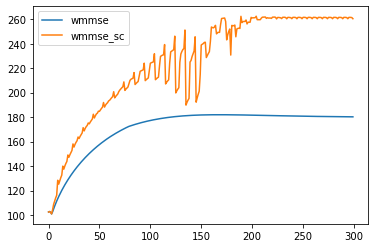

In [54]:
data = pd.DataFrame({
    'wmmse': rates_original_method,
    # 'wmmse_local': rates_local_method,
    'wmmse_sc': rates_sc_method,
    # 'wmmse_lr': rates_lr_method,
})
data.plot();